In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
def generate_particles(N, box_length=100, min_distance=3, temperature=100):
    # Generate positions
    positions = np.zeros((N, 3))
    num_attempts = 0
    for i in range(N):
        while True:
            new_position = np.random.uniform(low=0, high=box_length, size=3)
            if i == 0:
                break
            min_dist = np.min(np.linalg.norm(positions[:i] - new_position, axis=1))
            if min_dist >= min_distance:
                break
            num_attempts += 1
            if num_attempts > 1000:
                raise ValueError("Could not generate positions with given constraints.")
        positions[i] = new_position
    
    # Generate velocities from Maxwell-Boltzmann distribution
    m = 1  # mass of particles
    k = 1  # Boltzmann constant
    std_dev = np.sqrt(k * temperature / m)
    velocities = np.random.normal(loc=0, scale=std_dev, size=(N, 3))
    
    return positions, velocities

In [4]:
N = 108  # Number of particles
positions, velocities = generate_particles(N)

with open("abc.xyz", "a") as file:
    file.write("108\n")
    file.write("WOW\n")
    it = 0
    for k in positions:
        file.write("Ar" + str(it) + " " + str(k[0]) + " " + str(k[1]) + " " + str(k[2]) + "\n")
        it += 1

In [5]:
delta_matrix = positions[:, np.newaxis] - positions
mindist = 3
delta_matrix[delta_matrix < mindist] = mindist
# print(delta_matrix)

In [6]:
distance_matrix = np.sum(np.square(delta_matrix), axis=-1)

In [7]:
#print(distance_matrix)

In [8]:
def calculate_grad(pos, delta, dist, eps = 1, sig = 3.4):
    grad = []
    for i in range(len(pos)):
        for d in range(3):
            U = 0
            for j in range(len(pos)):
                if j != i:
                    U += (1/dist[i,j]**8 - 2 * sig**6 / dist[i,j]**14) * (delta_matrix[i, j, d])
            U *= 24 * eps * sig**6
            grad.append(U)
    gradients = np.array(grad).reshape(len(pos), 3)
    return gradients

In [9]:
def calculate_pot(dist, eps = 1, sig = 3.4):
    U = 0
    global N
    for i in range(N):
        for j in range(i+1,N):
            U += 4 * eps * (sig**12 / dist[i,j]**12 - sig**6 / dist[i,j]**6)
    return U

In [10]:
def opt(pos, delta, dis, max_iter = 500, alpha = 1, mindist = 3):
    i = 0
    pots = []
    #with open("abc.xyz", "a") as file:
    while i < max_iter:
        grads = calculate_grad(pos, delta, dis)
        # grads = gradient_total_energy(pos)
        pos -= alpha * grads
        pos = pos % 100
        delta = pos[:, np.newaxis] - pos
        delta[delta < mindist] = mindist
        dis = np.sqrt(np.sum(np.square(delta), axis=-1))
        pots.append(calculate_pot(dis))
        i += 1
        #if i > 10:
            #if np.abs(np.average(pots[-10:]) - pots[-1]) < 0.001:
                #break
            #file.write("108\n")
            #file.write("WOW\n")
            #for k in pos:
                #file.write("Ar " + str(k[0]) + " " + str(k[1]) + " " + str(k[2]) + "\n")
    return pos, pots

In [11]:
positions, pots = opt(positions, delta_matrix, distance_matrix)

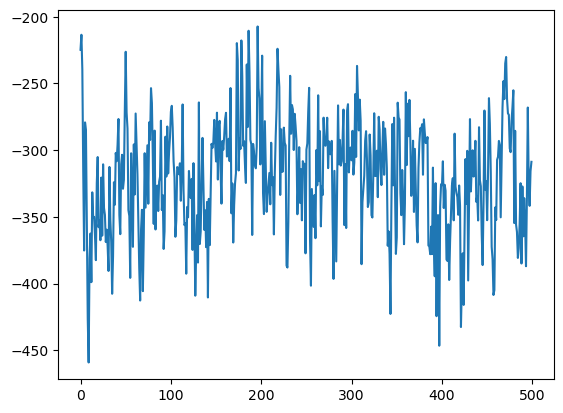

In [12]:
plt.plot(pots[:])
plt.show()

In [14]:
def trajectory(pos, vels, delta, dis, max_iter = 1500, alpha = 1):
    i = 0
    pots = []
    with open("traj.xyz", "a") as file:
        for i in tqdm(range(max_iter)):
            grads = calculate_grad(pos, delta, dis)
            # grads = gradient_total_energy(pos)
            vels -= grads * alpha
            pos += vels * alpha + alpha * alpha * grads/2
            pos = pos % 100
            delta = pos[:, np.newaxis] - pos
            delta[delta < mindist] = mindist
            dis = np.sum(np.square(delta), axis=-1)
            pots.append(calculate_pot(dis))
            # file.write("108\n")
            # file.write("WOW\n")
            # for k in pos:
                # file.write("Ar " + str(k[0]) + " " + str(k[1]) + " " + str(k[2]) + "\n")
    return pots

In [15]:
pots = trajectory(positions, velocities, delta_matrix, distance_matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:43<00:00, 34.19it/s]


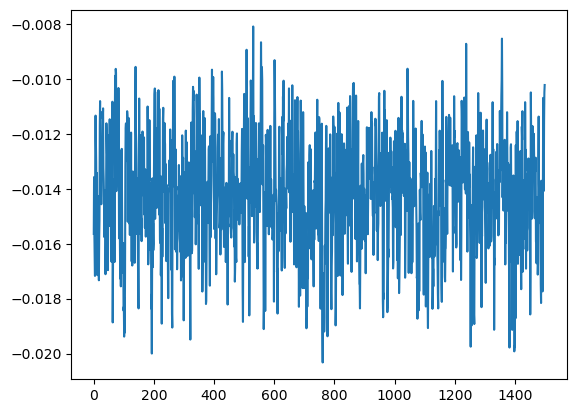

In [16]:
plt.plot(pots[:])
plt.show()